# HOST

**Author:** _Matteo Bagagli_ - **Date:** _10/2021_ - **Version:** _2.4.3_

-------------------------------------------------------------------------------------------------------------------

The **HOST** acronym stands for **H**igh-**O**rder-**ST**atistics seismic pickers.
This algorithm took inspiration from the one described in [_Baillard et al. 2014_](10.1785/0120120347). 
The idea behing this package is to provide user-friendly classes for seismic phase picking with _skewness_ and _kurtosis_ carachteristic-functions. I

Originally applied to seismograms by [_Saragiotis et al._](10.1109/TGRS.2002.800438), the HOS-CF are able to detect energic transient when the statistical properties of a seismogram (or time series) change abruptly. These CF are calculated on moving window with fixed window.

Measurements of statistical properties in a moving window are suitable for frequency-specific (or expected) transient. For this reason, the picker support a multi-window analysis, in order to collecto more information or even increase the quality of about 

**Both _skewness_ and _kurtosis_ are calculated with C-routine under the hood, making this package fast and suitable also for realtime picking porpouses.**

For the installation please refer to the `README.md` file in the project-home (for both standard and developer installation)


### Skewness CF

The skewness is defined as follows, using the 3rd central-moment third central moment of a continous distribution. 

$$
S=\frac{E\left[(X-E[X]]^{3}\right.}{E[X-E[X]]^{3 / 2}}=\frac{m_{3}}{m_{2}^{3 / 2}}
$$

The skewness provides information about positive or negative deviations of the distribution density function from the expectation value.

### Kurtosis CF

The kurtosis is defined as follows, using the 4th central-moment third central moment of a continous distribution. 

$$
K=\frac{E\left[(X-E[X]]^{4}\right.}{E[X-E[X]]^{4 / 2}}=\frac{m_{4}}{m_{2}^{2}}
$$

The kurtosis provides information about only positive deviations of the distribution density function from the expectation value.

# Quick-start!
-------------------------------------------------------

First, let's import the `ObsPy` library and the package main class `Host`. Once loaded the waveform, we do a first standard pre-processing of the data ...

In [1]:
# ----------------------------------------  To work
import sys
import logging
from obspy import read, UTCDateTime
from host.picker import Host
from host.plotting import plot_HOST

# ----------------------------------------  To show and log
%matplotlib inline 
logger = logging.getLogger()
logger.setLevel(logging.INFO)


def miniproc(st):
    prs = st.copy()
    prs.detrend('demean')
    prs.detrend('simple')
    prs.taper(max_percentage=0.05, type='cosine')
    prs.filter("bandpass",
               freqmin=1,
               freqmax=30,
               corners=2,
               zerophase=True)
    return prs

straw = read("../tests_data/obspy_read.mseed")
stproc = miniproc(straw)
trproc = stproc.select(channel="*Z")[0]
tr = trproc.copy()

As the trace contains the entire waveforms, we want to get close to the real onset ...

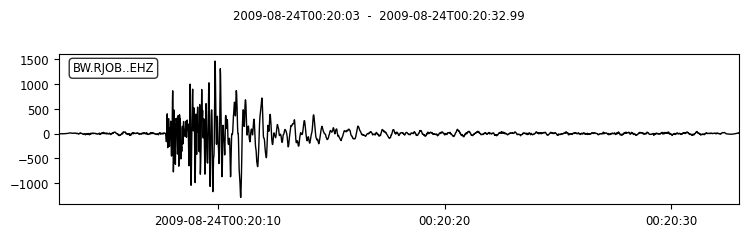

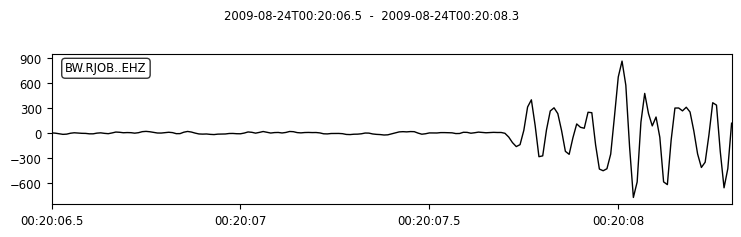

In [2]:
# Entire wave
tr.plot()

# Trimming
tr.trim(UTCDateTime("2009-08-24T00:20:06.500000"),
        UTCDateTime("2009-08-24T00:20:08.300000"))

tr.plot();


Now we want to initialize the main picker object, by providing the processed trace and the time-window (in seconds) for the CF calculation, and the `hos_method` (either `'skew'` or `'kurt'`) ...

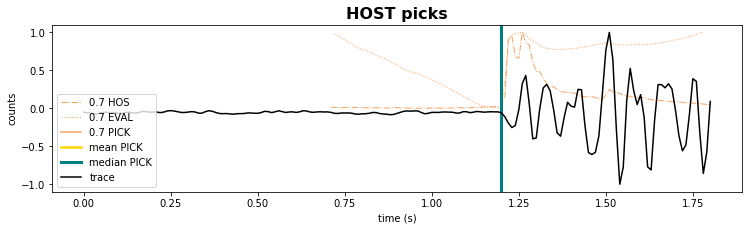

In [3]:
HP = Host(tr, 0.7, hos_method='kurtosis')  # also 'kurt' and 'k' works ... 
HP.work(debug_plot=True)

_NB: Please note that the CF values are normalized for the sake of clarity in the plot_

Now here's the debug plot of the HOST object, where we can see the simple kurtosis and, most important the _evaluation function_. This function is responsible for the pick definition. In this case, there's the default AIC function, calculated over the CF (in this case kurtosis). The pick is declared were the minimum of the AIC function is reached. 


Let's explain the legend entries now:
- **X.X HOS** represents the trace HOS-CF for the given time-window. In case of additional transformation, those are accounted as well, and the final plot will be the resulting one
- **X.X EVAL** represents the evaluation function (i.e. AIC or gaussian) for the given HOS-CF
- **X.X PICK** represents the pick obtained by the EVAL function.
- **mean pick** in case of multi-window approach, it represent the `mean-value` among them, otherwise it equals the single window one
- **median pick** in case of multi-window approach, it represent the `median-value` among them, otherwise it equals the single window one
- **trace** is just the input-trace

If we would like to use skewness in this case , we could use the `set_host_method` class-method, and see the outcome.

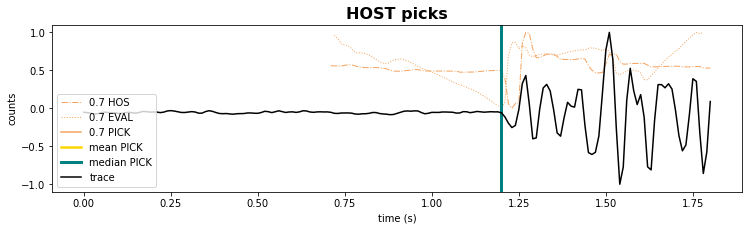

In [4]:
HP.set_hos_method('skewness')  # also 'skew' and 's' works ... 
HP.work(debug_plot=True)

With these simple cases, the detection of clear first arrival is, although it still strongly depends on the analysis time-window selection.
Now that you saw the fast-implementation, you could dig into the additional books to exploit the best from this package.

- _HOST_detection.ipynb_: will guide you through the different pick-detection methods.
- _HOST_transformation.ipynb_: will explain the different possibility to transform the HOST-CF to enanche its detection potential
- _HOST_multi-CF.ipynb_: will explore the possibility of a multi-HOSCF approach and the relative pick-error assessment.


### References
- Baillard, C., Crawford, W.C., Ballu, V., Hibert, C. and Mangeney, A., 2014. An automatic kurtosis‐based P‐and S‐phase picker designed for local seismic networks. Bulletin of the Seismological Society of America, 104(1), pp.394-409.
- Saragiotis, C.D., Hadjileontiadis, L.J. & Panas, S.M., 2002. PAI-S/K: a robust automatic seismic P phase arrival identification scheme, IEEE Trans. Geosci. Remote Sens. 40, 1395–1404.